# Model Code

In [1]:
from dataclasses import dataclass
import dataclasses
import torch
import jaxtyping
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import os


device = torch.device("cuda" if torch.cuda.is_available()
                    #   else "mps" if torch.backends.mps.is_available()
                      else "cpu")

@dataclass(frozen=True)
class Settings:
    # Number of features (aka d0 as we're not doing superposition input)
    m: int = 100
    # Feature sparsity
    s: int = 3
    # Hidden dims (number of neurons)
    d:int = 1000
    # Relative importance of non-zero outputs
    alpha: float = 100
    weight_decay: float = 0.000001
    is_semi: bool = False
    is_frozen: bool = False

# It's just handy to have these globally
def apply_settings():
    global m, s, d, alpha, weight_decay
    m = settings.m
    s = settings.s
    d = settings.d
    alpha = settings.alpha
    weight_decay = settings.weight_decay

settings = Settings()
apply_settings()

class MyModel(torch.nn.Module):
    def __init__(self, settings: Settings):
        super().__init__()
        self.linear = torch.nn.Linear(settings.m, settings.d)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(settings.d, settings.m**2)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
class SemiConstructedModel(torch.nn.Module):
    def __init__(self, settings: Settings):
        super().__init__()
        torch.manual_seed(42)
        self.raw_linear = torch.nn.parameter.Buffer(torch.rand((settings.d, settings.m), device=device))
        torch.seed()
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(settings.d, settings.m**2)
        self.bias = torch.nn.Parameter(torch.zeros(settings.d, device=device))
        self.p = torch.nn.Parameter(torch.tensor(0.1))
        self.pp = torch.nn.Parameter(torch.tensor(0.0))
        self.a = torch.nn.Parameter(torch.tensor(-1.0))
        self.b = torch.nn.Parameter(torch.tensor(1.0))


    def get_linear_weights(self):
        return torch.sigmoid((self.raw_linear - self.p) * torch.exp(self.pp)) * (self.b - self.a) + self.a

    @property
    def linear(self):
        layer = torch.nn.Linear(settings.m, settings.d, bias=True)
        layer.weight.data = self.get_linear_weights()
        layer.bias.data = self.bias
        return layer
        
    def forward(self, x):
        x = x @ self.get_linear_weights().T + self.bias
        x = self.relu(x)
        x = self.linear2(x)
        return x



In [2]:
def random_sparse_inputs(batch_size):
    x = torch.zeros(batch_size, m, device=device)

    # For each item in batch, randomly select k indices to set to 1
    # for i in range(batch_size):
    #     # Get k random indices between 0 and m-1
    #     indices = torch.randperm(m)[:k]
    #     x[i, indices] = 1

    indices = torch.multinomial(torch.ones(batch_size, m, device=device), s, replacement=False)
    x.scatter_(1, indices, 1)
    return x

def first_inputs():
    x = torch.zeros(1, m, device=device)
    x[0, :s] = 1
    return x

def random_first_inputs(batch_size, first=[1,1]):
    first = torch.tensor(first, device=device)
    first_len = first.shape[0]
    first_count = first.sum()
    x = torch.zeros(batch_size, m, device=device)
    indices = torch.multinomial(torch.ones(batch_size, m-first_len, device=device), s-first_count, replacement=False)
    x.scatter_(1, indices+first_len, 1)
    x[:, :first_len] = first[None, :]
    return x

def compute_expected(inputs):
    batch_size = inputs.shape[0]
    y = torch.zeros(batch_size, m, m, device=device)
    y = inputs[:, None, :] * inputs[:, :, None]
    y[:, range(m), range(m)] = 0
    y = y.view(batch_size, m**2)
    return y


mse = torch.nn.MSELoss()

def weighted_loss(outputs, targets):
    err = (outputs - targets)**2 
    err = err * (1 + targets * (alpha - 1))
    return err.mean()
    # err = mse(outputs, targets)
    # err += (alpha - 1) * mse(torch.where(targets == 0, 0, outputs), targets)
    # return err



In [9]:
def init_model(settings_):
    global model, optimizer, epoch, settings
    settings = settings_
    apply_settings()
    if settings.is_semi:
        model = SemiConstructedModel(settings)
    else:
        model = MyModel(settings)
    model.to(device)
    parameters = model.parameters() if not settings.is_frozen else model.linear2.parameters()
    optimizer = torch.optim.Adam(parameters, lr=0.001, weight_decay=settings.weight_decay)
    epoch = 0

def get_checkpoint_path(settings, epoch):
    return f'checkpoints/model_checkpoint_s{settings.s}_d{settings.d}_m{settings.m}_a{settings.alpha}_wd{settings.weight_decay}_e{epoch}{"_semi" if settings.is_semi else ""}{"_frozen" if settings.is_frozen else ""}.pth'

def save_model(checkpoint_path=None):
    # Save model checkpoint
    checkpoint_path = checkpoint_path or get_checkpoint_path(settings, epoch)
    torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'settings': dataclasses.asdict(settings),
                }, checkpoint_path)
    
def load_model(checkpoint_path=None):
    global epoch, settings, model, optimizer
    checkpoint_path = checkpoint_path or get_checkpoint_path(settings, epoch)
    checkpoint = torch.load(checkpoint_path)
    settings = Settings (**checkpoint['settings'])
    apply_settings()
    init_model(settings)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

init_model(Settings())


In [4]:
# print(f"a= {model.a.item()}, b= {model.b.item()}, p= {model.p.item()}, pp= {model.pp.item()}")
# print(f"a= {model.a.grad}, b= {model.b.grad}, p= {model.p.grad}, pp= {model.pp.grad}")

In [5]:
def train_model(model, batch_size=10000, n_epochs=3000, optimizer_=None, criterion=weighted_loss, start_epoch=0, plot_every=None):
    global epoch

    if optimizer_ is None:
        optimizer_ = optimizer

    criterion = weighted_loss

    progress_bar = tqdm(range(start_epoch, n_epochs))
    for epoch in progress_bar:
        # Generate random batch of sparse inputs
        inputs = random_sparse_inputs(batch_size)
        
        # Compute expected outputs
        targets = compute_expected(inputs)
        
        # Zero gradients
        optimizer_.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, targets)
        
        # Backward pass and optimize
        loss.backward()
        optimizer_.step()
        
        progress_bar.set_description(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.6f}')

        if plot_every is not None and epoch % plot_every == 0:
            scatter_plot(model)
            plt.savefig(f'plots3/scatter_plot_{epoch}.png')
            plt.close()
    epoch = n_epochs

#train_model(model, start_epoch=epoch, n_epochs=20000)


In [6]:
def test_model(model):
    with torch.no_grad():
        test_inputs = random_sparse_inputs(1000)
        test_outputs = model(test_inputs)
        expected_outputs = compute_expected(test_inputs)
        test_loss = weighted_loss(test_outputs, expected_outputs)
        return test_loss

# Plotting Code

In [16]:

def plot_output(model):
    """Draws a cropped picture of the output of the model."""
    with torch.no_grad():
        test_input = first_inputs()
        test_output = model(test_input)
    s2 = s * 3
    test_output_mini = test_output[0].reshape(m, m)[:s2, :s2]
    test_output_mini[range(s2), range(s2)] = float('nan')
    # Visualize the test output as a heatmap, with values normalized between 0 and 1
    plt.figure(figsize=(10, 10))
    plt.imshow(test_output_mini.cpu().numpy(), cmap='viridis')
    plt.clim(0, 1)
    plt.colorbar()
    plt.title(f'Model Output for Input with First {s} Elements = 1')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()


def plot_output_plotly(model):
    """Draws a cropped picture of the output of the model using plotly."""
    with torch.no_grad():
        test_input = first_inputs()
        test_output = model(test_input)
    s2 = s * 3
    test_output_mini = test_output[0].reshape(m, m)[:s2, :s2]
    test_output_mini[range(s2), range(s2)] = float('nan')
    # Visualize the test output as a heatmap, with values normalized between 0 and 1
    fig = go.Figure(data=go.Heatmap(
        z=test_output_mini.cpu().numpy(),
        colorscale='viridis',
        zmin=0,
        zmax=1
    ))
    fig.update_layout(
        title=f'Model Output for Input with First {s} Elements = 1',
        xaxis_title='Column Index',
        yaxis_title='Row Index'
    )
    fig.show()

plot_output_plotly(model)

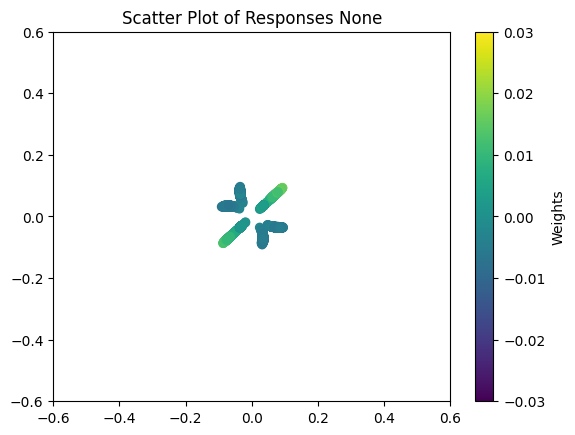

In [17]:
def scatter_plot(model, v0=0, v1=1, title=None):
    """Plots the responses of neurons to two given inputs"""
    assert v0 != v1
    resp0 = model.linear.weight[:, v0]
    resp1 = model.linear.weight[:, v1]
    weights = model.linear2.weight[v1*m + v0]
    plt.scatter(resp0.detach().cpu().numpy(), resp1.detach().cpu().numpy(), c=weights.detach().cpu().numpy(), vmin=-0.03, vmax=0.03)
    plt.xlim(-0.6,0.6)
    plt.ylim(-0.6,0.6)
    plt.colorbar(label='Weights')
    plt.title(f'Scatter Plot of Responses {title}')
    return plt
scatter_plot(model, 0, 1).show()


In [18]:
def binary_plot(model):
    weights = model.linear.weight.detach()
    u = []
    l = []
    s = []
    for i in range(d):
        mean = weights[i].mean()
        upper = weights[i][weights[i] > mean].median()
        lower = weights[i][weights[i] < mean].median()
        u.append(upper.item())
        l.append(lower.item())
        s.append((weights[i] > mean).sum().item() / m)
    plt.scatter(l, u, c=s, vmin=0, vmax=1)
    plt.xlabel('Lower')
    plt.ylabel('Upper')
    plt.colorbar(label='p')
    return plt

import plotly.graph_objects as go

def binary_plot_plotly(model, scale_weights=False):
    """Splits the weights of each neuron into upper and lower, and plots the pair.
    If the error bars are a mess, then the neuron is not binary.
    """
    weights = model.linear.weight.detach()
    if scale_weights:
            weights = weights * d
    u = []
    umin, umax = [], []
    l = []
    lmin, lmax = [], []
    s = []
    q = 0.1
    for i in range(d):
        mean = weights[i].mean()
        upper = weights[i][weights[i] >= mean]
        lower = weights[i][weights[i] < mean]
        um = upper.median().item()
        lm = lower.median().item()
        umin.append(um - torch.quantile(upper, 1- q).item())
        umax.append(torch.quantile(upper, q).item() - um)
        lmin.append(lm - torch.quantile(lower, 1- q).item())
        lmax.append(torch.quantile(lower, q).item() - lm)
        u.append(um)
        l.append(lm)
        s.append((weights[i] > mean).sum().item() / m)
    texts = [f'Upper: {u[i]:.4f}, Lower: {l[i]:.4f}, p: {s[i]:.4f}' for i in range(len(u))]
    fig = go.Figure(data=go.Scatter(x=l,
                                    y=u, 
                                    mode='markers',
                                    error_x=dict(type='data', symmetric=False, array=lmax, arrayminus=lmin, color='lightgrey', width=0),
                                    error_y=dict(type='data', symmetric=False, array=umax, arrayminus=umin, color='lightgrey', width=0),
                                    marker=dict(color=s, colorscale='Viridis', cmin=0, cmax=1, colorbar=dict(title='p')),
                                    hoverinfo='text',
                                    text=texts))
    fig.update_layout(xaxis_title='Lower', yaxis_title='Upper')
    return fig


# binary_plot_plotly(model).show()


In [13]:



def violin_plot(model):
    """Shows the distribution of weights for each neuron."""
    weights = model.linear.weight.detach().cpu().numpy()
    fig = go.Figure()
    for i in range(min(5, d)):
        fig.add_trace(go.Violin(y=weights[i], line_color='black', points='all', bandwidth=0.01, name=f'Neuron {i}', showlegend=False))
    fig.update_layout(title_text="Violin Plot of Weights")
    return fig




violin_plot(model).show()


In [14]:
def neuron_weight_plot(model, i):
    """Shows the weights of a neuron as a bar chart. Obsolete now we have violin plot."""
    plt.bar(range(len(model.linear.weight[i].detach().cpu().numpy())), model.linear.weight[i].detach().cpu().numpy())
    # plt.ylim(-0.05, 0.05)
    plt.axhline(y=model.linear.bias[i].detach().cpu().numpy(), color='r', linestyle='-')
    plt.title(f'Bar Chart of Neuron {i}')
    plt.xlabel('Index')
    plt.ylabel('Weight')
    plt.show()

# for i in range(min(5, d)):
#     neuron_weight_plot(model, i)

# Operations

Useful snippets to run as needed

In [ ]:
init_model(Settings(d=100))

In [155]:
save_model()

In [15]:
load_model('checkpoints/model_checkpoint_s3_d10000_m100_a100_wd1e-06_e6000.pth')


In [167]:
train_model(model, start_epoch=epoch, n_epochs=600000)

  0%|          | 0/535829 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Compute the loss
test_loss = test_model(model)
print(f'\nTest Loss: {test_loss.item():.6f}')

In [166]:
# optimizer.param_groups[0]['lr'] = 0.0001
# optimizer.param_groups[0]['weight_decay'] = 1e-7


Settings(m=100, s=3, d=100, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=False)

# Misc

In [29]:
# Construct weights for model similar to the original paper
import math
def construct_model(p=None, randomize=False):
    p = math.log(m)**2/math.sqrt(d) if p is None else p
    # expected_intersection = p*p*d
    # expected_false_positives = (k-1)*p
    # print(f"{p=}")
    # print(f"{expected_intersection=} {expected_false_positives=}")
    model = MyModel(settings)
    model.linear.weight.data = (torch.rand(d, m, device=device) < p).float()
    model.linear.bias.data = -torch.ones(d, device=device)
    model.linear2.bias.data = torch.zeros(m**2, device=device)
    weights2 = torch.zeros(m, m, d, device=device)
    l = model.linear.weight.data
    for i in range(m):
        for j in range(m):
            if i == j:
                continue
            # find intersecting set
            s = l[:, i] * l[:, j]
            ssum = s.sum()
            weights2[i, j, :] =  s / ssum if ssum > 0 else torch.zeros_like(s, device=device)
    model.linear2.weight.data = weights2.reshape(m**2, d)

    if randomize:
        rnd_scale = 0.01
        model.linear2.weight.data += torch.randn(m**2, d, device=device) * rnd_scale
        model.linear2.bias.data += torch.randn(m**2, device=device) * rnd_scale
        model.linear.weight.data += torch.randn(d, m, device=device) * rnd_scale
        model.linear.bias.data += torch.randn(d, device=device) * rnd_scale
    return model
model = construct_model(0.1, randomize=True)


100%|██████████| 20/20 [00:04<00:00,  4.95it/s]


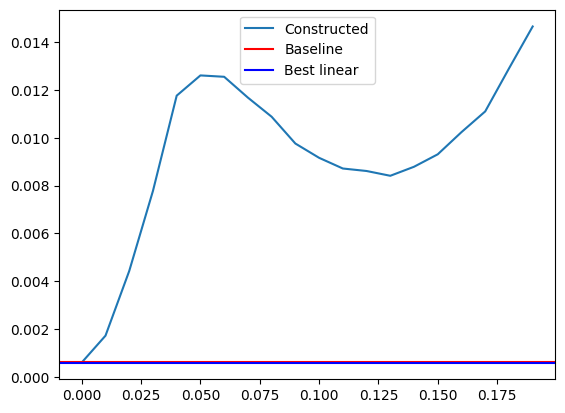

In [112]:
# # Loss from a model that just outputs 0
# baseline = s*(s-1)/m/m
# # Loss from a model that can solve an arbitrary 2m of the m*m outputs
# best_linear=(s*(s-1))/m/m * (m*m - 2*m)/m/m

# # Plot loss of constructed model for different p
# x = []
# y = []
# for p in tqdm.tqdm(torch.arange(0, 0.2, 0.01)):
#     p_model = construct_model(p)
#     p_test_loss = test_model(p_model)
#     # print(f"{p=} {p_test_loss=}")
#     x.append(p)
#     y.append(p_test_loss)
# plt.plot(x, y, label='Constructed')
# plt.axhline(baseline, color='red', label='Baseline')
# plt.axhline(best_linear, color='blue', label='Best linear')
# plt.legend()
# plt.show()


torch.Size([100])
torch.Size([100])


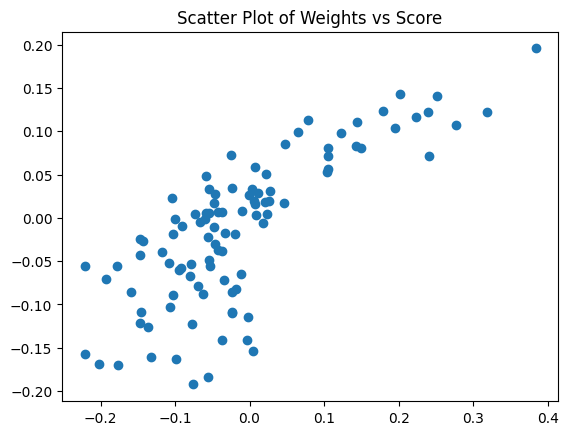

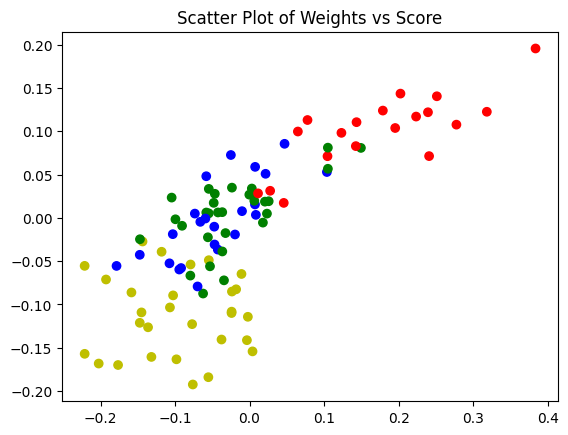

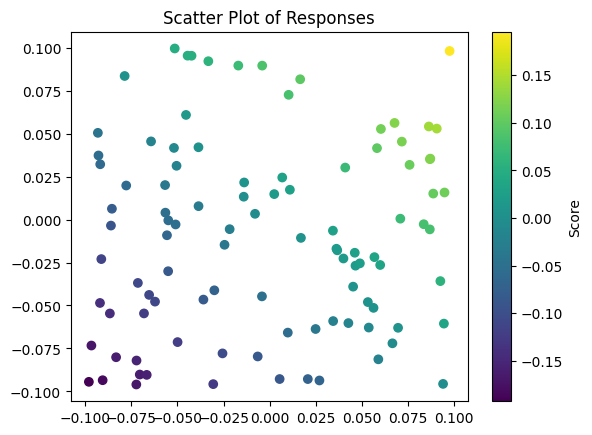

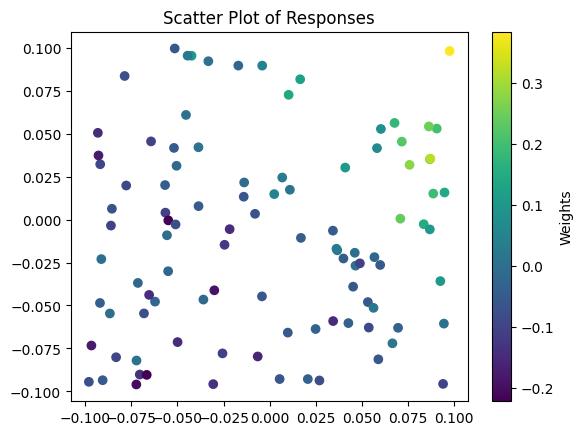

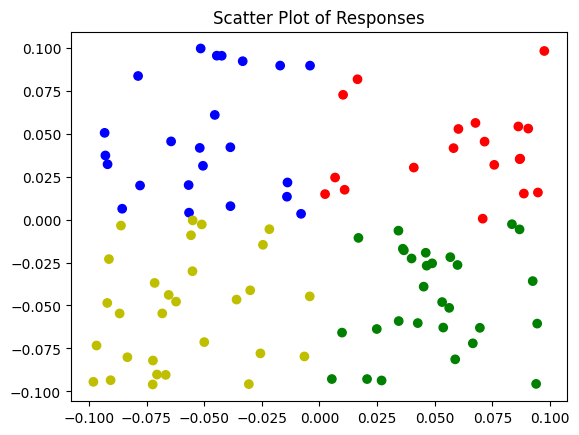

In [33]:
import numpy as np


# with torch.no_grad():
#     # Pre-relu intermidiate values under different asusmpts of the inputs
#     ints_00 = model.linear(random_first_inputs(10000, [0, 0])).mean(dim=0, keepdim=True)
#     ints_01 = model.linear(random_first_inputs(10000, [0, 1])).mean(dim=0, keepdim=True)
#     ints_10 = model.linear(random_first_inputs(10000, [1, 0])).mean(dim=0, keepdim=True)
#     ints_11 = model.linear(random_first_inputs(10000, [1, 1])).mean(dim=0, keepdim=True)


v0 = 0
v1 = 2

# How does each itnermediate value respond to each input?
resp0 = model.linear.weight[:, v0]
resp1 = model.linear.weight[:, v1]

weights = model.linear2.weight[v1*m + v0]

print(resp0.shape)
print(weights.shape)

# Color from quadrant
colors = np.where((resp0.detach().cpu().numpy() >= 0) & (resp1.detach().cpu().numpy() >= 0), 'r', 
         np.where((resp0.detach().cpu().numpy() >= 0) & (resp1.detach().cpu().numpy() < 0), 'g', 
         np.where((resp0.detach().cpu().numpy() < 0) & (resp1.detach().cpu().numpy() >= 0), 'b', 'y')))

# Color from angle
# angle = np.arctan2(resp1.detach().cpu().numpy(), resp0.detach().cpu().numpy())
# colors = np.mod(angle, 2*np.pi) / (2*np.pi)



# colors = []
# for r1, r2 in zip(resp0[0].detach().cpu().numpy(), resp1[0].detach().cpu().numpy()):
#     top = 0.15
#     bottom = -0.08
#     r3 = (r1 + r2) / 2
#     r1 = max(min((r1 - bottom) / (top - bottom), 1), 0)
#     r2 = max(min((r2 - bottom) / (top - bottom), 1), 0)
#     r3 = max(min((r3 - bottom) / (top - bottom), 1), 0)
#     colors.append((r1, r2, r3))

score = resp0 + resp1

def fit_circular_score(resp0, resp1, weights):
    x = torch.tensor([0.0], requires_grad=True, device=device)
    y = torch.tensor([0.0], requires_grad=True, device=device)
    a = torch.tensor([-1.0], requires_grad=True, device=device)
    b = torch.tensor([0.0], requires_grad=True, device=device)
    m1 = torch.tensor([0.0], requires_grad=True, device=device)
    m2 = torch.tensor([0.0], requires_grad=True, device=device)
    optimizer = torch.optim.Adam([x, y, a, b, m1, m2], lr=0.01)
    for i in tqdm.tqdm(range(1000), desc="Fitting circular score"):
        score = torch.sqrt((resp0.detach() - x)**2 + (resp1.detach() - y)**2) * a + b + m1 * resp0 + m2 * resp1
        loss = torch.mean((score - weights.detach())**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"x={x.item():10.4f}, y={y.item():10.4f}, a={a.item():10.4f}, b={b.item():10.4f}, m1={m1.item():10.4f}, m2={m2.item():10.4f}")
    return score

#score = fit_circular_score(resp0, resp1, weights)


# plt.hist(ints_11[0].detach().cpu().numpy(), bins=50)
# plt.title('Histogram')
# plt.show()

plt.scatter(weights.detach().cpu().numpy(), score.detach().cpu().numpy())
plt.title('Scatter Plot of Weights vs Score')
plt.show()
plt.scatter(weights.detach().cpu().numpy(), score.detach().cpu().numpy(), c=colors)
plt.title('Scatter Plot of Weights vs Score')
plt.show()


plt.scatter(resp0.detach().cpu().numpy(), resp1.detach().cpu().numpy(), c=score.detach().cpu().numpy())
plt.colorbar(label='Score')
plt.title('Scatter Plot of Responses')
plt.show()

plt.scatter(resp0.detach().cpu().numpy(), resp1.detach().cpu().numpy(), c=weights.detach().cpu().numpy())
plt.colorbar(label='Weights')
plt.title('Scatter Plot of Responses')
plt.show()
plt.scatter(resp0.detach().cpu().numpy(), resp1.detach().cpu().numpy(), c=colors)
plt.title('Scatter Plot of Responses')
plt.show()








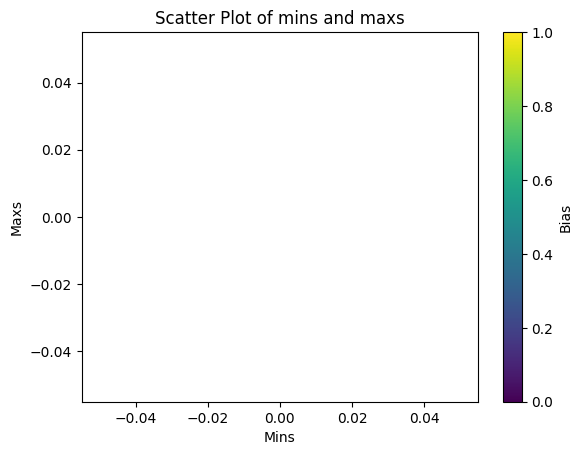

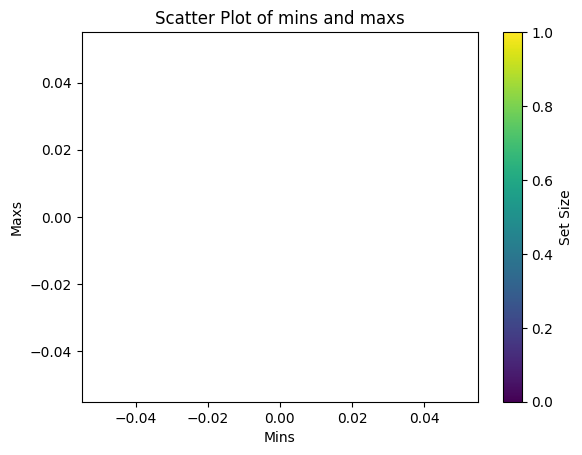

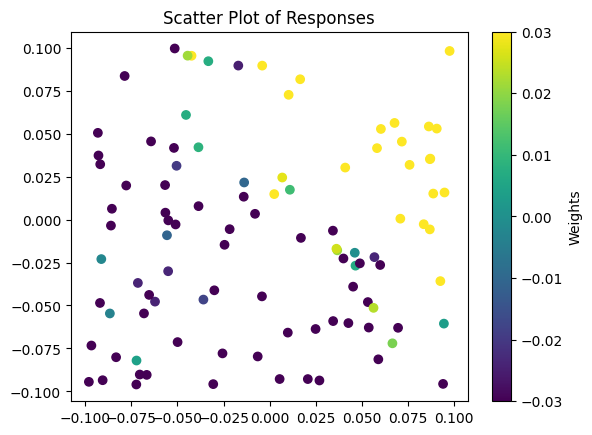

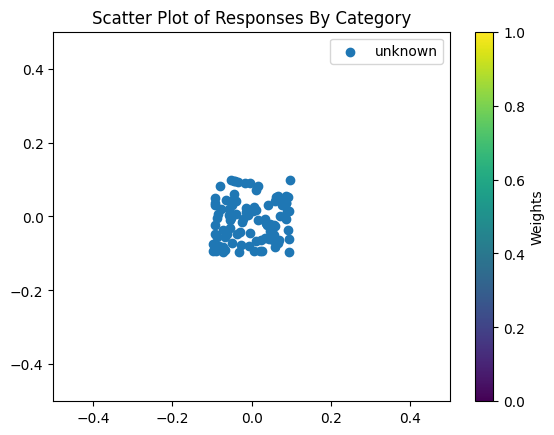

spikes 0
zero 0
C 0
B 0
unknown 100
unknown binary 0


In [36]:
def is_binary(x, eps=0.05):
    a = x.min()
    b = x.max()
    is_a = (x - a).abs() < eps
    is_b = (x - b).abs() < eps
    return (is_a | is_b).all()

def is_spike(x, eps=0.05):
    a = x.min()
    b = x.max()
    is_a = (x - a).abs() < eps
    is_b = (x - b).abs() < eps
    return (is_a | is_b).all() and sum(is_b) == 1

def categorize_neuron(x):
    eps = 0.05
    a = x.min()
    b = x.max()
    is_a = (x - a).abs() < eps
    is_b = (x - b).abs() < eps
    is_binary = (is_a | is_b).all()
    if not is_binary:
        return 'unknown'
    is_spike = is_binary and sum(is_b) <= 1
    if is_spike:
        return 'spike'
    if -0.01 < a and b < 0.01:
        return 'zero'
    if 0.04 < b < 0.06 and a < -0.10:
        return 'C'
    if a > -0.10:# and 1.8 < b / a < 2.2:
        return 'B'
    return 'unknown binary'

cats = np.array([categorize_neuron(model.linear.weight[x]) for x in range(d)])

is_bins = torch.tensor([is_binary(model.linear.weight[x]) for x in range(d)])
is_spikes = torch.tensor([is_spike(model.linear.weight[x]) for x in range(d)])

#print(bins)


model.linear.weight[is_bins].shape
indices = torch.where(is_bins)[0]
mins = model.linear.weight[is_bins].min(dim=1)[0]
maxs = model.linear.weight[is_bins].max(dim=1)[0]
S_size = (model.linear.weight[is_bins] > (maxs - 0.01)[:, None]).sum(dim=1)

plt.scatter(mins.detach().cpu().numpy(), maxs.detach().cpu().numpy(), c=model.linear.bias[is_bins].detach().cpu().numpy())
plt.title('Scatter Plot of mins and maxs')
plt.xlabel('Mins')
plt.ylabel('Maxs')
plt.colorbar(label='Bias')
plt.show()

plt.scatter(mins.detach().cpu().numpy(), maxs.detach().cpu().numpy(), c=S_size.detach().cpu().numpy())
plt.title('Scatter Plot of mins and maxs')
plt.xlabel('Mins')
plt.ylabel('Maxs')
plt.colorbar(label='Set Size')
plt.show()



def scatter_plot_cats(model, v0=0, v1=1):
    assert v0 != v1
    resp0 = model.linear.weight[:, v0]
    resp1 = model.linear.weight[:, v1]
    weights = model.linear2.weight[v1*m + v0]
    for cat in np.unique(cats):
        plt.scatter(resp0[cats == cat].detach().cpu().numpy(), resp1[cats == cat].detach().cpu().numpy(), label=cat)
    plt.legend()
    plt.colorbar(label='Weights')
    plt.title('Scatter Plot of Responses By Category')
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    return plt
scatter_plot(model, v0, v1).show()
scatter_plot_cats(model, v0, v1).show()

# for i, cat in enumerate(cats):
#     print(f"{i}: {cat}")

for i, (a, b) in enumerate(zip(mins, maxs)):
    i = indices[i]
    # if  b < 0.01 and a > -0.01:
    if b> 1.8:
        print(f"{i}: {a.item():10.4f}, {b.item():10.4f}, {model.linear.bias[i].item():10.4f}")


# print(model.linear2.weight.abs().max(dim=0).values)
print("spikes", (cats=='spike').sum())
print("zero", (cats=='zero').sum())
print("C", (cats=='C').sum())
print("B", (cats=='B').sum())
print("unknown", (cats=='unknown').sum())
print("unknown binary", (cats=='unknown binary').sum())











# Batch Experiments

In [7]:
# Run a range of experiments, saving the results
settings_range = [
    Settings(d=d, s=s)
    for s in [3]
    for d in list(range(100, 1000, 100)) + list(range(1000, 10000, 1000))
]
settings_range_progress = tqdm(settings_range)
for settings in settings_range_progress:
    n_epochs = 6000
    checkpoint_path = get_checkpoint_path(settings, n_epochs)
    if os.path.exists(checkpoint_path):
        continue
    print(f"Training model with settings: {settings}")
    init_model(settings)
    train_model(model, n_epochs=n_epochs)
    save_model(checkpoint_path)


  0%|          | 0/18 [00:00<?, ?it/s]

Training model with settings: Settings(m=100, s=3, d=8000, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=False)


  0%|          | 0/6000 [00:00<?, ?it/s]

Training model with settings: Settings(m=100, s=3, d=9000, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=False)


  0%|          | 0/6000 [00:00<?, ?it/s]

In [10]:

# Find cosign similarity between neurons
similarity = torch.nn.functional.cosine_similarity(
    model.linear.weight[:, 0:1],
    model.linear.weight,
    dim=0,
)
similarity[0] = 0

print(similarity)



tensor(19, device='cuda:0') tensor(0.0330, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(40, device='cuda:0') tensor(-0.0622, device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.0000, -0.0191, -0.0231, -0.0095, -0.0318, -0.0180,  0.0148,  0.0056,
        -0.0259, -0.0450, -0.0049,  0.0225,  0.0213,  0.0284,  0.0186, -0.0033,
        -0.0219, -0.0173, -0.0079,  0.0330, -0.0080, -0.0085, -0.0620, -0.0077,
         0.0201, -0.0417, -0.0194, -0.0279,  0.0017, -0.0219, -0.0251,  0.0004,
         0.0069, -0.0125, -0.0146, -0.0172,  0.0061, -0.0009,  0.0007,  0.0063,
        -0.0622, -0.0365,  0.0059,  0.0080, -0.0282, -0.0104, -0.0508, -0.0177,
        -0.0200,  0.0049,  0.0309, -0.0165, -0.0447, -0.0144, -0.0155, -0.0280,
         0.0019,  0.0022,  0.0104,  0.0069,  0.0090, -0.0164, -0.0205,  0.0015,
        -0.0101, -0.0022, -0.0140, -0.0274, -0.0067, -0.0230, -0.0211, -0.0059,
        -0.0127, -0.0314, -0.0364, -0.0014, -0.0006, -0.0005, -0.0051,  0.0026,
        -0.0212, -0.0075,

IndexError: too many indices for tensor of dimension 1

In [15]:
# Plots loss over a range of saved models
import glob

def collect_losses(epoch=6000, **kwargs):
    checkpoint_files = glob.glob(get_checkpoint_path(Settings(**kwargs), epoch))
    collected_losses = {}
    for checkpoint_file in checkpoint_files:
        load_model(checkpoint_file)
        loss = test_model(model)
        collected_losses[settings] = loss.item()
    return collected_losses

# Get all checkpoint files
collected_losses = collect_losses(d='*')
frozen_collected_losses = collect_losses(d='*', is_frozen=True)

print(collected_losses)
print(frozen_collected_losses)


{Settings(m=100, s=3, d=0, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=False): 0.0565740130841732, Settings(m=100, s=3, d=10000, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=False): 0.0004975253250449896, Settings(m=100, s=3, d=1000, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=False): 0.0026776515878736973, Settings(m=100, s=3, d=100, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=False): 0.011655719019472599, Settings(m=100, s=3, d=10, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=False): 0.04164271429181099, Settings(m=100, s=3, d=110, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=False): 0.011276967823505402, Settings(m=100, s=3, d=120, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=False): 0.010917593725025654, Settings(m=100, s=3, d=130, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=False): 0.010558721609413624, Settings(m=100, s=3, d=140, alpha=100, weight_decay=1e-06, is_semi=False, is_frozen=Fals

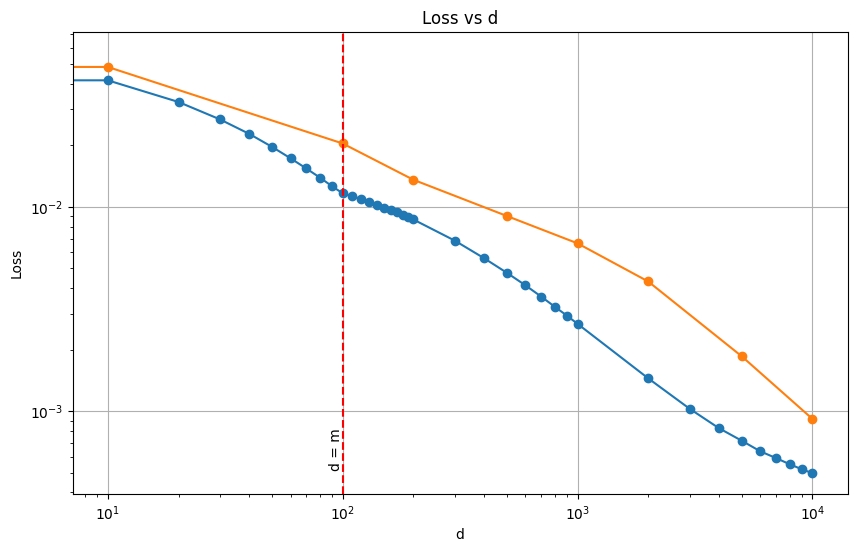

In [25]:

d_values = sorted([x.d for x in collected_losses])
loss_values = [collected_losses.get(Settings(d=d), float('nan')) for d in d_values]
frozen_d_values = sorted([x.d for x in frozen_collected_losses])
frozen_loss_values = [frozen_collected_losses.get(Settings(d=d, is_frozen=True), float('nan')) for d in frozen_d_values]
plt.figure(figsize=(10, 6))
plt.plot(d_values, loss_values, 'o-', label='Unfrozen')
plt.plot(frozen_d_values, frozen_loss_values, 'o-', label='Frozen')
plt.axvline(x=100, color='r', linestyle='--')
plt.text(100, 0.05, 'd = m', rotation=90, ha='right', va='bottom', transform=plt.gca().get_xaxis_transform())
plt.xscale('log')
plt.yscale('log')
plt.title('Loss vs d')
plt.xlabel('d')
plt.ylabel('Loss')
plt.grid(True)
plt.show()




In [ ]:
# Runs scatter plot over a range of saved models.

import re
checkpoint_files = glob.glob(get_checkpoint_path(Settings(d="*"), epoch))
def get_d(path):
    match = re.search("d(\d+)", path)
    return int(match[1])
for checkpoint_file in sorted(checkpoint_files, key=get_d):
    load_model(checkpoint_file)
    print(settings)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    plt.sca(ax1)
    scatter_plot(model, 0, 1, title=f"d={settings.d}")
    plt.sca(ax2)
    binary_plot(model)
    plt.show()

In [46]:
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider
import numpy as np

# Create a list to store all your figures
figures = {}
checkpoint_files = glob.glob(get_checkpoint_path(Settings(d="*"), epoch))
def get_d(path):
    match = re.search("d(\d+)", path)
    return int(match[1])

d_values = sorted(list(set([get_d(x) for x in checkpoint_files])))

# Generate all the figures (replace with your actual plotting code)
for checkpoint_file in checkpoint_files:
    load_model(checkpoint_file)
    figures[settings.d] = binary_plot_plotly(model)

# Create an interactive widget to display the figures
def show_plot(index):
    return figures[d_values[index]]

# Display the interactive widget in Jupyter
interact(show_plot, index=IntSlider(
    min=0, 
    max=len(d_values)-1, 
    step=1, 
    value=0,
    description="Plot Index:",
    continuous_update=True
))

# For standalone web use, you can save any individual plot as HTML:
# figures[0].write_html("plot_0.html")


c:\Users\Adam\Documents\Programming\Programming 2025\uand_toy\.venv\Lib\site-packages\torch\nn\init.py:511: UserWarning:

Initializing zero-element tensors is a no-op



interactive(children=(IntSlider(value=0, continuous_update=False, description='Plot Index:', max=37), Output()…

TypeError: keywords must be strings

In [119]:
import plotly.graph_objects as go
import numpy as np
import glob
import re

def get_d(path):
    match = re.search("d(\d+)", path)
    return int(match[1])

# Get all checkpoint files and d values
checkpoint_files = glob.glob(get_checkpoint_path(Settings(d="*"), epoch))
d_values = sorted(list(set([get_d(x) for x in checkpoint_files])))
del d_values[:1]


# Generate all the figures from your models
figures = {}
for checkpoint_file in checkpoint_files:
    load_model(checkpoint_file)
    figures[settings.d] = binary_plot_plotly(model)

# Find global min/max values across all plots
x_min, x_max = float('inf'), float('-inf')
y_min, y_max = float('inf'), float('-inf')

for d_value in d_values:
    fig = figures[d_value]
    
    # Examine each trace in the figure
    for trace in fig.data:
        if hasattr(trace, 'x') and len(trace.x) > 0:
            x_min = min(x_min, min(trace.x))
            x_max = max(x_max, max(trace.x))
        
        if hasattr(trace, 'y') and len(trace.y) > 0:
            y_min = min(y_min, min(trace.y))
            y_max = max(y_max, max(trace.y))

# Add some padding to the ranges (optional)
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05

x_min -= x_padding
x_max += x_padding
y_min -= y_padding
y_max += y_padding


# Create a single figure with frames for animation
main_fig = go.Figure()

# Add the base trace (first plot)
initial_frame_index = d_values.index(1000)
initial_d = d_values[initial_frame_index]
initial_fig = figures[initial_d]

# Copy the first figure's data to the main figure
for trace in initial_fig.data:
    main_fig.add_trace(trace)

# Copy layout properties from the first figure
main_fig.update_layout(
    title=initial_fig.layout.title,
    xaxis=initial_fig.layout.xaxis,
    yaxis=initial_fig.layout.yaxis,
    # Add any other layout properties you need
)

# Create frames for each d value
frames = []
for i, d_value in enumerate(d_values):
    fig = figures[d_value]
    
    frame = go.Frame(
        data=fig.data,
        name=str(i),
        layout=go.Layout(title=fig.layout.title)
    )
    frames.append(frame)

main_fig.frames = frames


# Configure slider
sliders = [{
    'active': initial_frame_index,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 16},
        'prefix': 'd value: ',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 0},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': [
        {
            'args': [
                [str(i)],
                {
                    'frame': {'duration': 0, 'redraw': True},
                    'mode': 'immediate',
                }
            ],
            'label': f"{d_value}",
            'method': 'animate'
        }
        for i, d_value in enumerate(d_values)
    ]
}]

# Update layout with slider
main_fig.update_layout(
    sliders=sliders,
    # Maintain the height and width from your original plots
    height=800,
    width=1000,
    # Set the fixed axis ranges
    xaxis=dict(range=[x_min, x_max]),
    yaxis=dict(range=[y_min, y_max]),
    
)

# Save as standalone HTML
main_fig.write_html("interactive_model_plots.html", auto_open=True, auto_play=False)

c:\Users\Adam\Documents\Programming\Programming 2025\uand_toy\.venv\Lib\site-packages\torch\nn\init.py:511: UserWarning:

Initializing zero-element tensors is a no-op

